# **XGBoost Model Implementation**

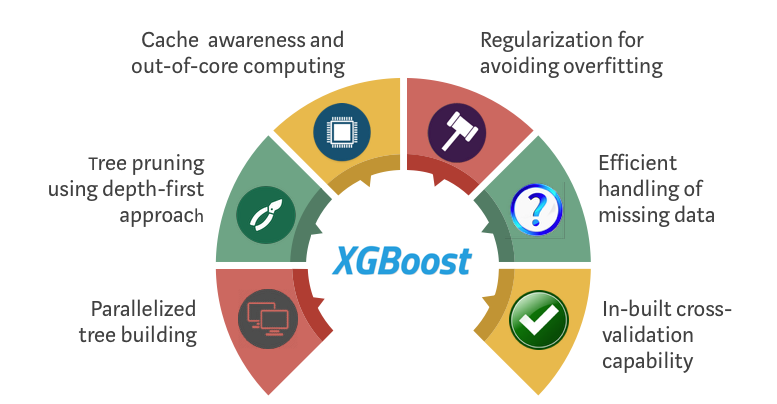

**XGBoost** is an advanced and more efficient implementation of Gradient Boosting Algorithm.

**Advantages over Other Boosting Techniques:**

* It is 10 times faster than the normal Gradient Boosting as it implements parallel processing. 
* It is highly flexible as users can define custom optimization objectives and evaluation criteria, has an inbuilt mechanism to handle missing values. 
* Unlike gradient boosting which stops splitting a node as soon as it encounters a negative loss, XG Boost splits up to the maximum depth specified and prunes the tree backward and removes splits beyond which there is an only negative loss.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### **Importing the data - (Here we are using the resampled data from our Class_Imbalance notebook)**

In [ ]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')

ParserError: ignored

In [ ]:
from memory_reduction import reduce_mem_usage

**Reducing memory usage for datasets**

In [ ]:
X_train = reduce_mem_usage(X_train)
y_train = reduce_mem_usage(y_train)
X_test = reduce_mem_usage(X_test)

Memory usage of dataframe is 738.66 MB
Memory usage after optimization is: 186.99 MB
Decreased by 74.7%
Memory usage of dataframe is 17.39 MB
Memory usage after optimization is: 5.43 MB
Decreased by 68.7%
Memory usage of dataframe is 614.65 MB
Memory usage after optimization is: 135.78 MB
Decreased by 77.9%


#### **Setting X_train, y_train & X_test**

* We won't be using train_test_split for the data because we have no y_test column since that is what we will be predicting. However we can use train_test_split for splitting traning data into training and validation data, in order to see how our model is performing. 

**Dropping the extra index column (Unnamed: 0) added when parsing dataframes**

In [ ]:
X_train.drop('Unnamed: 0',axis=1, inplace=True)
y_train.drop('Unnamed: 0',axis=1, inplace=True)
X_test.drop('Unnamed: 0',axis=1, inplace=True)

**We have already sorted the values by TransactionDT, timedelta feature**




In [ ]:
#X_train = X_train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', ],axis=1)
#y_train = y_train.sort_values('TransactionDT')['isFraud'].astype(bool)
#X_test = X_test.sort_values('TransactionDT').drop(['TransactionDT', ], axis=1)

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (1139754, 158)
y_train shape: (1139754, 1)
X_test shape: (506691, 158)


**Filling NaN values notarized by -1 to -999**

In [ ]:
X_train.replace(to_replace = -1, value = -999, inplace=True)
y_train.replace(to_replace = -1, value = -999, inplace=True)
X_test.replace(to_replace = -1, value = -999, inplace=True)

In [ ]:
X_train.head()

,TransactionID,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D14,D15,M1,...,C1_to_mean_addr2,C1_to_std_addr2,C1_to_mean_dist1,C1_to_std_dist1,C2_to_mean_addr1,C2_to_std_addr1,C2_to_mean_addr2,C2_to_std_addr2,C2_to_mean_dist1,C2_to_std_dist1,PCA_V_0,PCA_V_1,PCA_V_2,PCA_V_3,PCA_V_4,PCA_V_5,PCA_V_6,PCA_V_7,PCA_V_8,PCA_V_9,PCA_V_10,PCA_V_11,PCA_V_12,PCA_V_13,PCA_V_14,PCA_V_15,PCA_V_16,PCA_V_17,PCA_V_18,PCA_V_19,PCA_V_20,PCA_V_21,PCA_V_22,PCA_V_23,PCA_V_24,PCA_V_25,PCA_V_26,PCA_V_27,PCA_V_28,PCA_V_29
0,2987000.0,4.226562,4.0,3416.0,500.0,42.0,1.0,38.0,1.0,166.0,65.0,19.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,-999.0,13.0,-999.0,-999.0,-999.0,-999.0,-999.0,13.0,13.0,-999.0,-999.0,0.0,1.0,...,0.104919,0.019379,0.120422,0.036011,0.130859,0.029251,0.110535,0.018448,0.134644,0.040741,0.374756,0.909180,0.159180,0.896973,0.189331,-0.027542,0.031525,-0.173096,0.014000,0.024216,-0.018219,-0.034332,-0.123291,0.013222,-0.014397,0.076172,0.032654,0.012947,-0.012138,-0.008698,-0.005699,-0.002466,0.018723,-0.005238,0.006531,-0.045319,-0.034210,-0.053741,0.026672,-0.060516
1,2987001.0,3.367188,4.0,7920.0,303.0,42.0,2.0,2.0,1.0,173.0,65.0,-999.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,2.0,...,0.104919,0.019379,-999.000000,-999.000000,0.124390,0.021454,0.110535,0.018448,-999.000000,-999.000000,-0.057159,-0.172119,0.629883,0.453125,-0.438477,0.038239,-0.096375,-0.050079,0.000414,0.005173,0.077026,-0.130981,-0.085510,-0.043732,-0.016922,0.015350,0.003777,0.017746,-0.012070,0.001741,-0.039368,0.003017,0.012375,-0.002649,-0.004078,0.008934,0.029266,0.029114,-0.023621,-0.037689
2,2987002.0,4.078125,4.0,9384.0,389.0,42.0,4.0,58.0,2.0,178.0,65.0,287.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,0.0,315.0,-999.0,-999.0,315.0,1.0,...,0.104919,0.019379,0.456299,0.753418,0.116455,0.017685,0.110535,0.018448,0.567871,0.957520,-0.347168,0.210938,0.766602,0.227051,0.069214,-0.025726,0.083496,-0.176514,0.059845,0.017334,-0.021301,-0.012100,0.003212,0.010880,-0.042267,0.017624,-0.011185,-0.001363,-0.016678,-0.000590,-0.009560,0.002848,-0.003054,0.002321,-0.005459,-0.001485,-0.000145,0.001475,0.004406,0.000626
3,2987003.0,3.912109,4.0,6992.0,466.0,42.0,2.0,14.0,2.0,282.0,65.0,-999.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,-999.0,-999.0,-999.0,84.0,-999.0,-999.0,-999.0,111.0,2.0,...,0.209839,0.038757,-999.000000,-999.000000,0.685547,0.101257,0.552734,0.092224,-999.000000,-999.000000,-0.190918,-0.130981,0.684082,0.438232,-0.424805,0.055695,-0.041962,-0.176880,0.165771,0.064514,-0.032745,0.140625,0.035736,-0.043671,-0.014610,-0.023804,-0.026154,0.034119,0.134399,-0.053589,0.063416,0.024902,0.013138,0.026688,-0.002556,0.027267,0.053802,0.033844,-0.015182,-0.017883
4,2987004.0,3.912109,1.0,9264.0,413.0,42.0,2.0,2.0,1.0,241.0,65.0,-999.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2.0,...,0.104919,0.019379,-999.000000,-999.000000,0.116882,0.013092,0.110535,0.018448,-999.000000,-999.000000,2.810547,-0.055969,0.622070,-0.219727,0.266602,1.117188,-0.074158,-0.132202,-0.293945,-0.086243,-0.016876,0.077637,-0.168579,0.015015,-0.001257,0.004368,-0.000573,-0.020493,0.006176,-0.011879,0.013397,-0.011978,0.007103,0.074768,0.026657,0.023148,-0.041290,-0.004898,-0.000383,0.008095


In [ ]:
# Making y_train into a 1-D array with boolean values 0-False, 1-True
y_train = y_train['isFraud'].astype(bool)
y_train.head()

0    False
1    False
2    False
3    False
4    False
Name: isFraud, dtype: bool

## **1. XGBoost - Basic Classifier**
* ### **Default parameters with eval_set and eval_metric**

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

**Splitting training data into training and validation sets**

In [ ]:
x_tra, x_val, y_tra, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42 )

* #### **Implementing and training a default XGBoost classifier**

In [ ]:
xgb = xgboost.XGBClassifier(n_estimators=250, random_state=200, seed=42)

# define the eval set and metric
eval_set=[(x_tra, y_tra),(x_val,y_val)]
eval_metric = ["auc", "error"]

# fit the model
xgb.fit(x_tra, y_tra, eval_set = eval_set, eval_metric=eval_metric, verbose=False)


**Predicting target variable for x_val and classification report**

In [ ]:
y_pred_val = xgb.predict(x_val)
y_pred_proba = xgb.predict_proba(x_val)

# Model assessment
print(classification_report(y_val, y_pred_val))
print('\nAccuracy on Validation set: {: .3f}'.format(accuracy_score(y_val, y_pred_val)))
print('Error: {: .3f}'.format(1 - accuracy_score(y_val, y_pred_val)))

              precision    recall  f1-score   support

       False       0.82      0.88      0.85    113928
        True       0.87      0.81      0.84    114023

    accuracy                           0.84    227951
   macro avg       0.84      0.84      0.84    227951
weighted avg       0.84      0.84      0.84    227951


Accuracy on Validation set:  0.843
Error:  0.157


* #### **Plotting performance eval metrics (AUC-ROC & Error)**

In [ ]:
def plotting_metrics(model):
  results = model.evals_result_
  epochs = len(results['validation_0']['error'])
  x_axis = range(0, epochs)

  fig, ax = plt.subplots(1, 2, figsize=(18,6))

  # plotting auc-roc curve
  ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
  ax[0].plot(x_axis, results['validation_1']['auc'], label='Val')
  ax[0].legend(fontsize=13)
  ax[0].set_title('XGBoost AUC-ROC\n', fontsize=15)
  ax[0].set_ylabel('AUC-ROC\n')
  ax[0].set_xlabel('\nN estimators')

  # plotting classification error
  ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
  ax[1].plot(x_axis, results['validation_1']['error'], label='Val')
  ax[1].legend(fontsize=13)
  ax[1].set_title('XGBoost Classification Error\n', fontsize=15)
  ax[1].set_ylabel('Classification Error\n')
  ax[1].set_xlabel('\nN estimators')

  # displaying results
  plt.show()
  plt.tight_layout()

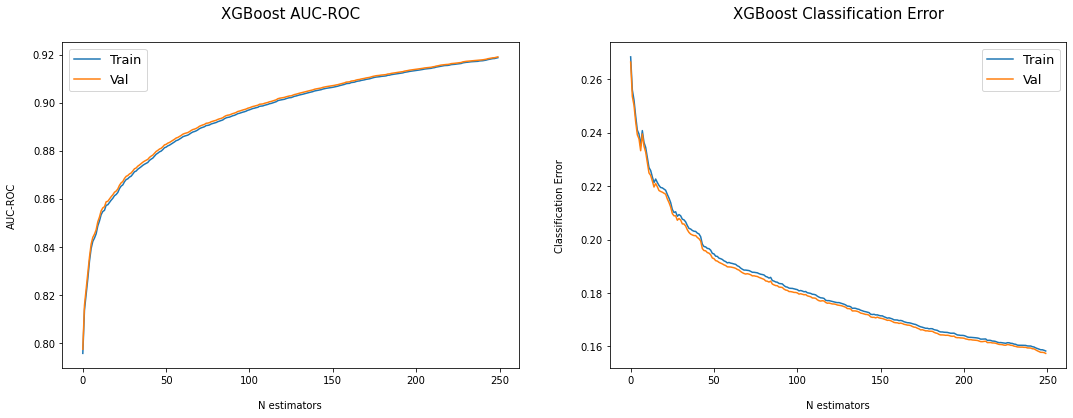

<Figure size 432x288 with 0 Axes>

In [ ]:
# retrieve and plot performance metrics
results = xgb.evals_result_
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(1, 2, figsize=(18,6))

# plot auc-roc curve
ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[0].plot(x_axis, results['validation_1']['auc'], label='Val')
ax[0].legend(fontsize=13)
ax[0].set_title('XGBoost AUC-ROC\n', fontsize=15)
ax[0].set_ylabel('AUC-ROC\n')
ax[0].set_xlabel('\nN estimators')

# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Val')
ax[1].legend(fontsize=13)
ax[1].set_title('XGBoost Classification Error\n', fontsize=15)
ax[1].set_ylabel('Classification Error\n')
ax[1].set_xlabel('\nN estimators')

plt.show()
plt.tight_layout()

* ### **Feature Importance Visualization**

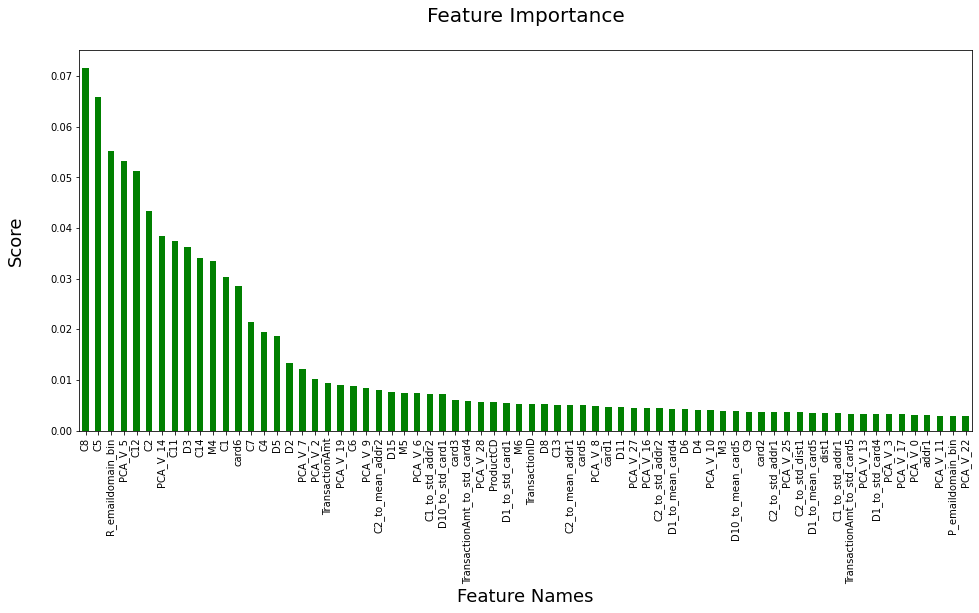

In [ ]:
plot_df = pd.DataFrame([np.array(list(X_train.columns)), list(xgb.feature_importances_)]).T
plot_df.columns = ['Feature Name', 'Score']
plot_df.sort_values('Score', ascending = False, inplace = True)
plot_df.set_index('Feature Name', inplace = True)

plot_df.iloc[:70].plot(kind = 'bar', legend = False, figsize = (16,7), color="g", align="center")
plt.title("Feature Importance\n", fontsize=20)
plt.xticks(fontsize = 10)
plt.xlabel('Feature Names', fontsize=18)
plt.ylabel('Score\n', fontsize =18)
plt.show()

**Selecting all columns that had a feature importance score of > 0**

In [ ]:
X_train_ = X_train[['C8','C5','R_emaildomain_bin', 'PCA_V_5','C12','C2','PCA_V_14','C11','D3','C14',
                    'M4','C1','card6','C7','C4','D5','D2','PCA_V_7','PCA_V_2','TransactionAmt',
                    'PCA_V_19','C6','PCA_V_9', 'C2_to_mean_addr2','D15','M5','PCA_V_6','C1_to_std_addr2',
                    'D1_to_std_card1', 'M6','TransactionID','D8','C13','C2_to_mean_addr1','card5',
                    'PCA_V_8','card1','D11','PCA_V_27','PCA_V_16','C2_to_std_addr2','D1_to_mean_card4',
                    'D6','D4','PCA_V_10','M3','D10_to_mean_card5','C9','card2','C2_to_std_addr1','PCA_V_25',
                    'C2_to_std_dist1','D1_to_mean_card5','dist1','C1_to_std_addr1', 'TransactionAmt_to_std_card5',
                    'PCA_V_13','D1_to_std_card4','PCA_V_3','PCA_V_17','PCA_V_0','addr1','PCA_V_11','P_emaildomain_bin',
                    'PCA_V_22', 'C10','PCA_V_15','D1_to_std_card5','PCA_V_18','D10_to_mean_card1','C2_to_mean_dist1',
                    'TransactionAmt_to_std_card1','D1_to_mean_card1','PCA_V_1', 'C1_to_mean_addr1','P_emaildomain_suffix',
                    'D14','PCA_V_26','TransactionAmt_to_mean_card5','D1','PCA_V_24','C3','PCA_V_29','TransactionAmt_to_mean_card1',
                    'C1_to_std_dist1','TransactionAmt_to_mean_card4', 'PCA_V_4','PCA_V_20','M9','M2','PCA_V_23', 
                    'V2','D10_to_std_card5','R_emaildomain_suffix','id_31','id_17','PCA_V_12','id_02_to_mean_card1',
                    'id_34','D9','D10_to_mean_card4']]

X_test_ = X_test[['C8','C5','R_emaildomain_bin', 'PCA_V_5','C12','C2','PCA_V_14','C11','D3','C14',
                    'M4','C1','card6','C7','C4','D5','D2','PCA_V_7','PCA_V_2','TransactionAmt',
                    'PCA_V_19','C6','PCA_V_9', 'C2_to_mean_addr2','D15','M5','PCA_V_6','C1_to_std_addr2',
                    'D1_to_std_card1', 'M6','TransactionID','D8','C13','C2_to_mean_addr1','card5',
                    'PCA_V_8','card1','D11','PCA_V_27','PCA_V_16','C2_to_std_addr2','D1_to_mean_card4',
                    'D6','D4','PCA_V_10','M3','D10_to_mean_card5','C9','card2','C2_to_std_addr1','PCA_V_25',
                    'C2_to_std_dist1','D1_to_mean_card5','dist1','C1_to_std_addr1', 'TransactionAmt_to_std_card5',
                    'PCA_V_13','D1_to_std_card4','PCA_V_3','PCA_V_17','PCA_V_0','addr1','PCA_V_11','P_emaildomain_bin',
                    'PCA_V_22', 'C10','PCA_V_15','D1_to_std_card5','PCA_V_18','D10_to_mean_card1','C2_to_mean_dist1',
                    'TransactionAmt_to_std_card1','D1_to_mean_card1','PCA_V_1', 'C1_to_mean_addr1','P_emaildomain_suffix',
                    'D14','PCA_V_26','TransactionAmt_to_mean_card5','D1','PCA_V_24','C3','PCA_V_29','TransactionAmt_to_mean_card1',
                    'C1_to_std_dist1','TransactionAmt_to_mean_card4', 'PCA_V_4','PCA_V_20','M9','M2','PCA_V_23', 
                    'V2','D10_to_std_card5','R_emaildomain_suffix','id_31','id_17','PCA_V_12','id_02_to_mean_card1',
                    'id_34','D9','D10_to_mean_card4']]


In [ ]:
print('X_train shape: {}'.format(X_train_.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test_.shape))

X_train shape: (1139754, 101)
y_train shape: (1139754,)
X_test shape: (506691, 101)


#### **Final Data manipulation**

In [ ]:
# Train data
X_train.to_csv('X_train_final.csv')
y_train.to_csv('y_train_final.csv')

# Test data
X_test.to_csv('X_test_final.csv')
